# Enoncé
## Contexte
**Mon rôle** : data scientist

**Commanditaire** : Prêt à dépenser

**Activité de l'entreprise :** société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt

**Projet :** mettre en œuvre un outil de “scoring crédit”

**Type de Mission :** classification binaire déséquilibrée

## Attendus
**But de la mission :** classifie la demande en crédit accordé ou refusé en s’appuyant sur des sources de données variées 

**Base de données :** https://www.kaggle.com/c/home-credit-default-risk/data (données comportementales, données provenant d'autres institutions financières, ...)

**Etapes demandées :**
1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
==> les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit

**Détails de la mission :** 
Le dashboard interactif devra contenir au minimum les fonctionnalités suivantes :
- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

**Livrables demandés :** 
- **Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.**
- Un dossier sur un outil de versioning de code contenant :
    - Le code de la modélisation (du prétraitement à la prédiction)
    - Le code générant le dashboard
    - Le code permettant de déployer le modèle sous forme d'API
- Une note méthodologique décrivant :
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
- Un support de présentation pour la soutenance, détaillant le travail réalisé.

# Librairies et paramétrages
## Mise à jour des librairies

In [1]:
'''
import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'])
'''

"\nimport re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'])\n"

## Importations des librairies

In [2]:
# Gestion des données
import pandas as pd
import numpy as np

# Gestion des graphiques
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
# corrélation variable numérique
from scipy.stats import shapiro, normaltest, levene, kruskal, mannwhitneyu
# corrélation variable catégorielle
from scipy.stats import chi2_contingency

## Paramétrages

In [3]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", None) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.4f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

# Importation et Nettoyage des données

In [4]:
path = 'datafiles/'

In [5]:
df_desc = pd.read_csv(path+'HomeCredit_columns_description.csv'
                   , sep = ','
                   , encoding = 'iso-8859-1')
for table in df_desc.Table.unique():
    print('----------------------')
    print(table)
    print('----------------------')
    for columns, desc in zip(df_desc.loc[df_desc['Table'] == table, 'Row'],
                             df_desc.loc[df_desc['Table'] == table, 'Description']):
        print(columns,':',desc)
del df_desc

----------------------
application_{train|test}.csv
----------------------
SK_ID_CURR : ID of loan in our sample
TARGET : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
NAME_CONTRACT_TYPE : Identification if loan is cash or revolving
CODE_GENDER : Gender of the client
FLAG_OWN_CAR : Flag if the client owns a car
FLAG_OWN_REALTY : Flag if client owns a house or flat
CNT_CHILDREN : Number of children the client has
AMT_INCOME_TOTAL : Income of the client
AMT_CREDIT : Credit amount of the loan
AMT_ANNUITY : Loan annuity
AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given
NAME_TYPE_SUITE : Who was accompanying client when he was applying for the loan
NAME_INCOME_TYPE : Clients income type (businessman, working, maternity leave,)
NAME_EDUCATION_TYPE : Level of highest education the client achieved
NAME_FAMILY_

Avec ce fichier de descriptions des données, on peut voir que la variable cible TARGET représente les clients en difficulté de paiement sur au moins 1 des premières échéances de paiement (TARGET = 1).

Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
Little feature selection is done and overfitting might be a problem since many features are related.
The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features
All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
You can use LightGBM with KFold or Stratified KFold.

Update 16/06/2018:
- Added Payment Rate feature
- Removed index from features
- Use standard KFold CV (not stratified)

#Traduction#

La plupart des fonctionnalités sont créées en appliquant les fonctions min, max, moyenne, somme et var à des tables groupées.
Peu de fonctionnalités sont sélectionnées et le surajustement peut être un problème car de nombreuses fonctionnalités sont liées.
Les idées clés suivantes ont été utilisées :
- Divisez ou soustrayez des caractéristiques importantes pour obtenir des taux (comme la rente et le revenu)
- Dans Bureau Data : créer des fonctionnalités spécifiques pour les crédits actifs et les crédits fermés
- Dans les applications précédentes : créez des fonctionnalités spécifiques pour les applications approuvées et refusées
- Modularité : une fonction pour chaque table (sauf bureau_balance et application_test)
- Encodage à chaud pour les fonctionnalités catégorielles
Toutes les tables sont jointes au DF de l'application à l'aide de la clé SK_ID_CURR (sauf bureau_balance).
Vous pouvez utiliser LightGBM avec KFold ou Stratified KFold.

Mise à jour 16/06/2018 :
- Ajout de la fonctionnalité de taux de paiement
- Suppression de l'index des fonctionnalités
- Utiliser le CV standard KFold (non stratifié)

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
def impute_na_cat(df):
    
    df_cat = df.select_dtypes(include = object) 
    
    for column in df_cat.columns.to_list():
        
        df[column] = df[column].str.upper()
    
    df_na = df_cat.isna().any()
    
    for column in df_na.index.to_list():
        
        df.loc[df[column].isna(), column] = 'INCONNU' 
    
    return df

## Importations
### Application train / test

In [8]:
# Read data
df = pd.read_csv(path+'application_train.csv')
test_df = pd.read_csv(path+'application_test.csv')
print("Train samples: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))
print("Test samples: {:,} rows ; {:,} columns".format(test_df.shape[0], test_df.shape[1]).replace(',',' '))

# Merge data
df = pd.concat([df,test_df], ignore_index = True).reset_index(drop = True)
del test_df

# Impute NA in categorical series
df = impute_na_cat(df)

df.head()

Train samples: 307 511 rows ; 122 colmuns
Test samples: 48 744 rows ; 121 columns


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0000,CASH LOANS,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,UNACCOMPANIED,WORKING,SECONDARY / SECONDARY SPECIAL,SINGLE / NOT MARRIED,HOUSE / APARTMENT,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,LABORERS,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,BUSINESS ENTITY TYPE 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,REG OPER ACCOUNT,BLOCK OF FLATS,0.0149,"STONE, BRICK",NO,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0.0000,CASH LOANS,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,FAMILY,STATE SERVANT,HIGHER EDUCATION,MARRIED,HOUSE / APARTMENT,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,CORE STAFF,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,SCHOOL,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,REG OPER ACCOUNT,BLOCK OF FLATS,0.0714,BLOCK,NO,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0.0000,REVOLVING LOANS,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,UNACCOMPANIED,WORKING,SECONDARY / SECONDARY SPECIAL,SINGLE / NOT MARRIED,HOUSE / APARTMENT,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,LABORERS,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,GOVERNMEN

In [9]:
# Remove 4 rows with 'XNA' as CODE_GENDER (wrong answer)
df = df[df['CODE_GENDER'] != 'XNA']
df = df.reset_index(drop = True)

# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
df, cat_cols = one_hot_encoder(df)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

df.head()

Data application: 356 251 rows ; 254 colmuns


,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_CASH LOANS,NAME_CONTRACT_TYPE_REVOLVING LOANS,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP OF PEOPLE,NAME_TYPE_SUITE_INCONNU,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,"NAME_TYPE_SUITE_SPOUSE, PARTNER",NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL ASSOCIATE,NAME_INCOME_TYPE_MATERNITY LEAVE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_ACADEMIC DEGREE,NAME_EDUCATION_TYPE_HIGHER EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE HIGHER,NAME_EDUCATION_TYPE_LOWER SECONDARY,NAME_EDUCATION_TYPE_SECONDARY / SECONDARY SPECIAL,NAME_FAMILY_STATUS_CIVIL MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE / NOT MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO-OP APARTMENT,NAME_HOUSING_TYPE_HOUSE / APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL APARTMENT,NAME_HOUSING_TYPE_OFFICE APARTMENT,NAME_HOUSING_TYPE_RENTED APARTMENT,NAME_HOUSING_TYPE_WITH PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING STAFF,OCCUPATION_TYPE_COOKING STAFF,OCCUPATION_TYPE_CORE STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HIGH SKILL TECH STAFF,OCCUPATION_TYPE_HR STAFF,OCCUPATION_TYPE_INCONNU,OCCUPATION_TYPE_IT STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW-SKILL LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE STAFF,OCCUPATION_TYPE_PRIVATE SERVICE STAFF,OCCUPATION_TYPE_REALTY AGENTS,OCCUPATION_TYPE_SALES STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY STAFF,OCCUPATION_TYPE_WAITERS/BARMEN STAFF,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS ENTI

### Bureau / Bureau Balance

In [10]:
bureau = pd.read_csv(path+'bureau.csv')
bb = pd.read_csv(path+'bureau_balance.csv')
print("Bureau samples: {:,} rows ; {:,} columns".format(bureau.shape[0], bureau.shape[1]).replace(',',' '))
print("Bureau balance samples: {:,} rows ; {:,} columns".format(bb.shape[0], bb.shape[1]).replace(',',' '))

# Impute NA in categorical series
bureau = impute_na_cat(bureau)
bb = impute_na_cat(bb)

bureau.head()

Bureau samples: 1 716 428 rows ; 17 columns
Bureau balance samples: 27 299 925 rows ; 3 columns


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,CLOSED,CURRENCY 1,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,CONSUMER CREDIT,-131,NaN
1,215354,5714463,ACTIVE,CURRENCY 1,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,CREDIT CARD,-20,NaN
2,215354,5714464,ACTIVE,CURRENCY 1,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,CONSUMER CREDIT,-16,NaN
3,215354,5714465,ACTIVE,CURRENCY 1,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,CREDIT CARD,-16,NaN
4,215354,5714466,ACTIVE,CURRENCY 1,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,CONSUMER CREDIT,-21,NaN


In [11]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [12]:
# Bureau and bureau_balance : Encoding categorical variable
bureau, bureau_cat = one_hot_encoder(bureau)
bb, bb_cat = one_hot_encoder(bb)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
del bb_aggregations
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how = 'left', on = 'SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis = 1, inplace = True)
del bb, bb_agg

# Bureau and bureau_balance : numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
del bureau_cat, bb_cat

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
del cat_aggregations

# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_ACTIVE'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how = 'left', on = 'SK_ID_CURR')
del active, active_agg

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_CLOSED'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how = 'left', on = 'SK_ID_CURR')
del closed, closed_agg, bureau, num_aggregations

print("Bureau data: {:,} rows ; {:,} columns".format(bureau_agg.shape[0],bureau_agg.shape[1]).replace(',',' '))
bureau_agg.head()

Bureau data: 305 811 rows ; 112 columns


,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_ACTIVE_MEAN,BURO_CREDIT_ACTIVE_BAD DEBT_MEAN,BURO_CREDIT_ACTIVE_CLOSED_MEAN,BURO_CREDIT_ACTIVE_SOLD_MEAN,BURO_CREDIT_CURRENCY_CURRENCY 1_MEAN,BURO_CREDIT_CURRENCY_CURRENCY 2_MEAN,BURO_CREDIT_CURRENCY_CURRENCY 3_MEAN,BURO_CREDIT_CURRENCY_CURRENCY 4_MEAN,BURO_CREDIT_TYPE_ANOTHER TYPE OF LOAN_MEAN,BURO_CREDIT_TYPE_CAR LOAN_MEAN,BURO_CREDIT_TYPE_CASH LOAN (NON-EARMARKED)_MEAN,BURO_CREDIT_TYPE_CONSUMER CREDIT_MEAN,BURO_CREDIT_TYPE_CREDIT CARD_MEAN,BURO_CREDIT_TYPE_INTERBANK CREDIT_MEAN,BURO_CREDIT_TYPE_LOAN FOR BUSINESS DEVELOPMENT_MEAN,BURO_CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_MEAN,BURO_CREDIT_TYPE_LOAN FOR THE PURCHASE OF EQUIPMENT_MEAN,BURO_CREDIT_TYPE_LOAN FOR WORKING CAPITAL REPLENISHMENT_MEAN,BURO_CREDIT_TYPE_MICROLOAN_MEAN,BURO_CREDIT_TYPE_MOBILE OPERATOR LOAN_MEAN,BURO_CREDIT_TYPE_MORTGAGE_MEAN,BURO_CREDIT_TYPE_REAL ESTATE LOAN_MEAN,BURO_CREDIT_TYPE_UNKNOWN TYPE OF LOAN_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.0000,240043.6667,-1329.0000,1778.0000,82.4286,-93.1429,0,0.0000,NaN,378000.0000,207623.5714,1453365.0000,373239.0000,85240.9286,596686.5000,0.0000,0.0000,0.0000,10822.5000,3545.3571,0,-51.0000,0.0000,24.5714,172.0000,0.4286,0.0000,0.5714,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3367,0.0075,0.0000,0.0000,0.0000,0.0000,0.441

In [13]:
df = df.join(bureau_agg, how = 'left', on = 'SK_ID_CURR')
del bureau_agg
print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

Data application: 356 251 rows ; 366 colmuns


### Previous application

In [14]:
prev = pd.read_csv(path+'previous_application.csv')
print("Previous application samples: {:,} rows ; {:,} columns".format(prev.shape[0],prev.shape[1]).replace(',',' '))

# Impute NA in categorical series
prev = impute_na_cat(prev)

prev.head()

Previous application samples: 1 670 214 rows ; 37 columns


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,CONSUMER LOANS,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,1,0.0000,0.1828,0.8673,XAP,APPROVED,-73,CASH THROUGH THE BANK,XAP,INCONNU,REPEATER,MOBILE,POS,XNA,COUNTRY-WIDE,35,CONNECTIVITY,12.0000,MIDDLE,POS MOBILE WITH INTEREST,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,CASH LOANS,25188.6150,607500.0000,679671.0000,NaN,607500.0000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,APPROVED,-164,XNA,XAP,UNACCOMPANIED,REPEATER,XNA,CASH,X-SELL,CONTACT CENTER,-1,XNA,36.0000,LOW_ACTION,CASH X-SELL: LOW,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,CASH LOANS,15060.7350,112500.0000,136444.5000,NaN,112500.0000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,APPROVED,-301,CASH THROUGH THE BANK,XAP,"SPOUSE, PARTNER",REPEATER,XNA,CASH,X-SELL,CREDIT AND CASH OFFICES,-1,XNA,12.0000,HIGH,CASH X-SELL: HIGH,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,CASH LOANS,47041.3350,450000.0000,470790.0000,NaN,450000.0000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,APPROVED,-512,CASH THROUGH THE BANK,XAP,INCONNU,REPEATER,XNA,CASH,X-SELL,CREDIT AND CASH OFFICES,-1,XNA,12.0000,MIDDLE,CASH X-SELL: MIDDLE,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,CASH LOANS,31924.3950,337500.0000,404055.0000,NaN,337500.0000,THURSDAY,9,Y,1,NaN,NaN,NaN,REPAIRS,REFUSED,-781,CASH THROUGH THE BANK,HC,INCONNU,REPEATER,XNA,CASH,WALK-IN,CREDIT AND CASH OFFICES,-1,XNA,24.0000,HIGH,CASH STREET: HIGH,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Encoding categorical variable
prev, cat_cols = one_hot_encoder(prev)

# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_APPROVED'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how = 'left', on = 'SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_REFUSED'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how = 'left', on = 'SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev

print("Previous data: {:,} rows ; {:,} columns".format(prev_agg.shape[0],prev_agg.shape[1]).replace(',',' '))
prev_agg.head()

Previous data: 338 857 rows ; 235 columns


,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_TYPE_CASH LOANS_MEAN,PREV_NAME_CONTRACT_TYPE_CONSUMER LOANS_MEAN,PREV_NAME_CONTRACT_TYPE_REVOLVING LOANS_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUILDING A HOUSE OR AN ANNEX_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUSINESS DEVELOPMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUYING A GARAGE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUYING A HOLIDAY HOME / LAND_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUYING A HOME_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUYING A NEW CAR_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_BUYING A USED CAR_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_CAR REPAIRS_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_EDUCATION_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_EVERYDAY EXPENSES_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_FURNITURE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_GASIFICATION / WATER SUPPLY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_HOBBY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_JOURNEY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_MEDICINE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_MONEY FOR A THIRD PERSON_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_OTHER_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_PAYMENTS ON OTHER LOANS_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_PURCHASE OF ELECTRONIC EQUIPMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_REFUSAL TO NAME THE GOAL_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_REPAIRS_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_URGENT NEEDS_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_WEDDING / GIFT / HOLIDAY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN,PREV_NAME_CONTRACT_STATUS_CANCELED_MEAN,PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN,PREV_NAME_CONTRACT_STATUS_UNUSED OFFER_MEAN,PREV_NAME_PAYMENT_TYPE_CASH THROUGH THE BANK_MEAN,PREV_NAME_PAYMENT_TYPE_CASHLESS FROM THE ACCOUNT OF THE EMPLOYER_MEAN,PREV_NAME_PAYMENT_TYPE_NON-CASH FROM YOUR ACCOUNT_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_CHILDREN_MEAN,PREV_NAME_TYPE_SUITE_FAMILY_MEAN,PREV_NAME_TYPE_SUITE_GROUP OF PEOPLE_MEAN,PREV_NAME_TYPE_SUITE_INCONNU_MEAN,PREV_NAME_TYPE_SUITE_OTHER_A_MEAN,PREV_NAME_TYPE_SUITE_OTHER_B_MEAN,"PREV_NAME_TYPE_SUITE_SPOUSE, PARTNER_MEAN",PREV_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN,PREV_NAME_CLIENT_TYPE_NEW_MEAN,PREV_NAME_CLIENT_TYPE_REFRESHED_MEAN,PREV_NAME_CLIENT_TYPE_REPEATER_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_ADDITIONAL SERVICE_MEAN,PREV_NAME_GOODS_CATEGORY_ANIMALS_MEAN,PREV_NAME_GOODS_CATEGORY_AUDIO/VIDEO_MEAN,PREV_NAME_GOODS_CATEGORY_AUTO ACCESSORIES_MEAN,PREV_NAME_GOODS_CATEGORY_CLOTHING AND ACCESSORIES_MEAN,PREV_NAME_GOODS_CATEGORY_COMPUTERS_MEAN,PREV_NAME_GOODS_CATEGORY_CONSTRUCTION MATERIALS_MEAN,PREV_NAME_GOODS_CAT

In [16]:
df = df.join(prev_agg, how = 'left', on = 'SK_ID_CURR')
del prev_agg
print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

Data application: 356 251 rows ; 601 colmuns


### POS CASH Balance

In [17]:
pos = pd.read_csv(path+'POS_CASH_balance.csv')
print("POS CASH Balance samples: {:,} rows ; {:,} columns".format(pos.shape[0],pos.shape[1]).replace(',',' '))

# Impute NA in categorical series
pos = impute_na_cat(pos)

pos.head()

POS CASH Balance samples: 10 001 358 rows ; 8 columns


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,ACTIVE,0,0
1,1715348,367990,-33,36.0000,35.0000,ACTIVE,0,0
2,1784872,397406,-32,12.0000,9.0000,ACTIVE,0,0
3,1903291,269225,-35,48.0000,42.0000,ACTIVE,0,0
4,2341044,334279,-35,36.0000,35.0000,ACTIVE,0,0


In [18]:
# Encoding categorical variable
pos, cat_cols = one_hot_encoder(pos)

# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos

print("POS CASH data: {:,} rows ; {:,} columns".format(pos_agg.shape[0],pos_agg.shape[1]).replace(',',' '))
pos_agg.head()

POS CASH data: 337 252 rows ; 17 columns


,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_AMORTIZED DEBT_MEAN,POS_NAME_CONTRACT_STATUS_APPROVED_MEAN,POS_NAME_CONTRACT_STATUS_CANCELED_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_DEMAND_MEAN,POS_NAME_CONTRACT_STATUS_RETURNED TO THE STORE_MEAN,POS_NAME_CONTRACT_STATUS_SIGNED_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,
100001,-53,-72.5556,9,7,0.7778,7,0.7778,0.7778,0.0000,0.0000,0.0000,0.2222,0.0000,0.0000,0.0000,0.0000,9
100002,-1,-10.0000,19,0,0.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,19
100003,-18,-43.7857,28,0,0.0000,0,0.0000,0.9286,0.0000,0.0000,0.0000,0.0714,0.0000,0.0000,0.0000,0.0000,28
100004,-24,-25.5000,4,0,0.0000,0,0.0000,0.7500,0.0000,0.0000,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,4
100005,-15,-20.0000,11,0,0.0000,0,0.0000,0.8182,0.0000,0.0000,0.0000,0.0909,0.0000,0.0000,0.0909,0.0000,11


In [19]:
df = df.join(pos_agg, how = 'left', on = 'SK_ID_CURR')
del pos_agg
print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

Data application: 356 251 rows ; 618 colmuns


### Installments payements

In [20]:
ins = pd.read_csv(path+'installments_payments.csv')
print("Installments payments samples: {:,} rows ; {:,} columns".format(ins.shape[0],ins.shape[1]).replace(',',' '))

# Impute NA in categorical series
ins = impute_na_cat(ins)

ins.head()

Installments payments samples: 13 605 401 rows ; 8 columns


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1300,24350.1300
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850


In [21]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins

print("Installments payments data: {:,} rows ; {:,} columns".format(ins_agg.shape[0],ins_agg.shape[0]).replace(',',' '))
ins_agg.head()

Installments payments data: 339 587 rows ; 339 587 columns


,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0000,1.5714,11.0000,36.0000,8.8571,62.0000,1.0000,1.0000,7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17397.9000,5885.1321,41195.9250,3951.0000,17397.9000,5885.1321,41195.9250,-1628.0000,-2195.0000,-15365.0000,7
100002,2,0.0000,0.0000,0.0000,31.0000,20.4211,388.0000,1.0000,1.0000,19.0000,0.0000,0.0000,0.0000,0.0000,0.0000,53093.7450,11559.2471,219625.6950,9251.7750,53093.7450,11559.2471,219625.6950,-49.0000,-315.4211,-5993.0000,19
100003,2,0.0000,0.0000,0.0000,14.0000,7.1600,179.0000,1.0000,1.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,560835.3600,64754.5860,1618864.6500,6662.9700,560835.3600,64754.5860,1618864.6500,-544.0000,-1385.3200,-34633.0000,25
100004,2,0.0000,0.0000,0.0000,11.0000,7.6667,23.0000,1.0000,1.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10573.9650,7096.1550,21288.4650,5357.2500,10573.9650,7096.1550,21288.4650,-727.0000,-761.6667,-2285.0000,3
100005,2,1.0000,0.1111,1.0000,37.0000,23.6667,213.0000,1.0000,1.0000,9.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17656.2450,6240.2050,56161.8450,4813.2000,17656.2450,6240.2050,56161.8450,-470.0000,-609.5556,-5486.0000,9


In [22]:
df = df.join(ins_agg, how = 'left', on = 'SK_ID_CURR')
del ins_agg
print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

Data application: 356 251 rows ; 644 colmuns


### Credit Balance

In [23]:
cc = pd.read_csv(path+'credit_card_balance.csv')
print("Credit Balance samples: {:,} rows ; {:,} columns".format(cc.shape[0],cc.shape[1]).replace(',',' '))

# Impute NA in categorical series
cc = impute_na_cat(cc)

cc.head()

Credit Balance samples: 3 840 312 rows ; 23 columns


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,1800.0000,1800.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,ACTIVE,0,0
1,2582071,363914,-1,63975.5550,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,60175.0800,64875.5550,64875.5550,1.0000,1,0.0000,0.0000,69.0000,ACTIVE,0,0
2,1740877,371185,-7,31815.2250,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,26926.4250,31460.0850,31460.0850,0.0000,0,0.0000,0.0000,30.0000,ACTIVE,0,0
3,1389973,337855,-4,236572.1100,225000,2250.0000,2250.0000,0.0000,0.0000,11795.7600,11925.0000,11925.0000,224949.2850,233048.9700,233048.9700,1.0000,1,0.0000,0.0000,10.0000,ACTIVE,0,0
4,1891521,126868,-1,453919.4550,450000,0.0000,11547.0000,0.0000,11547.0000,22924.8900,27000.0000,27000.0000,443044.3950,453919.4550,453919.4550,0.0000,1,0.0000,1.0000,101.0000,ACTIVE,0,0


In [24]:
# Encoding categorical variable
cc, cat_cols = one_hot_encoder(cc)

# General aggregations
cc.drop(['SK_ID_PREV'], axis = 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc

print("Credit Balance data: {:,} rows {:,} columns".format(cc_agg.shape[0],cc_agg.shape[1]).replace(',',' '))
cc_agg.head()

Credit Balance data: 103 558 rows 136 columns


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_ACTIVE_MIN,CC_NAME_CONTRACT_STATUS_ACTIVE_MAX,CC_NAME_CONTRACT_STATUS_ACTIVE_MEAN,CC_NAME_CONTRACT_STATUS_ACTIVE_SUM,CC_NAME_CONTRACT_STATUS_ACTIVE_VAR,CC_NAME_CONTRACT_STATUS_APPROVED_MIN,CC_NAME_CONTRACT_STATUS_APPROVED_MAX,CC_NAME_CONTRACT_STATUS_APPROVED_MEAN,CC_NAME_CONTRACT_STATUS_APPROVED_SUM,CC_NAME_CONTRACT_STATUS_APPROVED_VAR,CC_NAME_CONTRACT_STATUS_COMPLETED_MIN,CC_NAME_CONTRACT_STATUS_COMPLETED_MAX,CC_NAME_CONTRACT_STATUS_COMPLETED_MEAN,CC_NAME_CONTRACT_STATUS_COMPLETED_SUM,CC_NAME_CONTRACT_STATUS_COMPLETED_VAR,CC_NAME_CONTRACT_STATUS_DEMAND_MIN,CC_NAME_CONTRACT_STATUS_DEMAND_MAX,CC_NAME_CONTRACT_STATUS_DEMAND_MEAN,CC_NAME_CONTRACT_STATUS_DEMAND_SUM,CC_NAME_CONTRACT_STATUS_DEMAND_VAR,CC_NAME_CONTRACT_STATUS_REFUSED_MIN,CC_NAME_CONTRACT_STATUS_REFUSED_MAX,CC_NAME_CONTRACT_STATUS_REFUSED_MEAN,CC_NAME_CONTRACT_STATUS_REFUSED_SUM,CC_NAME_CONTRACT_STATUS_REFUSED_VAR,CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_MIN,CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_MAX,CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MIN,CC_NAME_CONTRACT_S

In [25]:
df = df.join(cc_agg, how = 'left', on = 'SK_ID_CURR')
del cc_agg
print("Data application: {:,} rows ; {:,} colmuns".format(df.shape[0], df.shape[1]).replace(',',' '))

Data application: 356 251 rows ; 780 colmuns


## Nettoyage

In [26]:
df.replace([np.inf, -np.inf], np.nan, inplace = True)

# Clients issus de "Application train" pour modélisation (entrainement, validation, optimisation)
df_train = df.loc[~df['TARGET'].isna(),:].copy()
# Clients issus de "Application test" pour dashboard
df_test = df.loc[df['TARGET'].isna(),:].copy()
df_test.drop(columns = 'TARGET', inplace = True)

del df

In [27]:
# TARGET : Float to Int to str
df_train['TARGET'] = df_train['TARGET'].astype('Int64')
df_train['TARGET'] = df_train['TARGET'].astype(str)

### Variables

In [28]:
# suppression des variables n'ayant qu'une modalité : numérique comme catégorielle
i = 0
for col in df_train.columns.to_list():
    if df_train[col].nunique() < 2:
        print('Suppression de la colonne',col)
        df_train.drop(columns = col, inplace = True)
        df_test.drop(columns = col, inplace = True)
        i += 1
print("Suppression de",i,"colonnes")

Suppression de la colonne PREV_NAME_GOODS_CATEGORY_HOUSE CONSTRUCTION_MEAN
Suppression de la colonne CC_SK_DPD_MIN
Suppression de la colonne CC_SK_DPD_DEF_MIN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_APPROVED_MIN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_DEMAND_MIN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_REFUSED_MIN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_MIN
Suppression de 7 colonnes


In [29]:
# suppression des variables numériques à seulement deux modalités, mais dont la modalité minimal concerne moins d'1% du data set
i = 0
minSize = df_train.shape[0] *.01
for col in df_train.columns.to_list():
    if (df_train[col].nunique() == 2):
        if (df_train[col].unique().tolist() != [0.,1.]):
            if (df_train[col].unique().tolist() != [1.,0.]):
                if (df_train[col].value_counts().min() < minSize):
                    print('Suppression de la colonne',col)
                    df_train.drop(columns = col, inplace = True)
                    df_test.drop(columns = col, inplace = True)
                    i += 1
print("Suppression de",i,"colonnes")

Suppression de la colonne BURO_CREDIT_TYPE_INTERBANK CREDIT_MEAN
Suppression de la colonne BURO_CREDIT_TYPE_MOBILE OPERATOR LOAN_MEAN
Suppression de la colonne PREV_NAME_GOODS_CATEGORY_ANIMALS_MEAN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_ACTIVE_MAX
Suppression de la colonne CC_NAME_CONTRACT_STATUS_APPROVED_MAX
Suppression de la colonne CC_NAME_CONTRACT_STATUS_APPROVED_SUM
Suppression de la colonne CC_NAME_CONTRACT_STATUS_COMPLETED_MIN
Suppression de la colonne CC_NAME_CONTRACT_STATUS_DEMAND_MAX
Suppression de la colonne CC_NAME_CONTRACT_STATUS_REFUSED_MAX
Suppression de la colonne CC_NAME_CONTRACT_STATUS_REFUSED_SUM
Suppression de la colonne CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_MAX
Suppression de la colonne CC_NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM
Suppression de la colonne CC_NAME_CONTRACT_STATUS_SIGNED_MIN
Suppression de 13 colonnes


In [30]:
catCol = []
numCol = []
for col in df_train.columns.to_list():
    if (col != 'SK_ID_CURR') & (col != 'TARGET'): # mémorisation des types des features (id et cible ne sont pas des features)
        if (col.endswith(('MIN', 'MAX', 'MEAN', 'SUM', 'VAR'))
           ) | (df_train[col].nunique() > 2): # si une aggregation est affichée dans le nom OU qu'elle a + de 2 valeurs uniques
            numCol.append(col) # ==> feature numérique
        elif df_train[col].nunique() == 2: # si aucune aggregation n'est affichée dans le nom & qu'elle a 2 valeurs uniques
            catCol.append(col) # ==> feature catégorielle

print('Nb features numériques :',len(numCol))
print('Nb features catégorielles :',len(catCol))

Nb features numériques : 583
Nb features catégorielles : 175


### Valeurs aberrantes

In [31]:
'''
for col in numCol:
    if (df_train[col].skew() > -0.5) & (df_train[col].skew() < 0.5): # distribution symétrique
        mean = df_train[col].mean()
        sigma = df_train[col].std(ddof = 0)
        limBas = mean - 3 * sigma
        limHaut = mean + 3 * sigma
    else: # distribution asymétrique
        q1 = df_train[col].quantile(.25)
        q3 = df_train[col].quantile(.75)
        iqr = q3 - q1
        limBas = q1 - 1.5 * iqr
        limHaut = q3 + 1.5 * iqr
    nb_modif = df_train.loc[(df_train[col] < limBas)|(df_train[col] > limHaut), col].shape[0]
    if nb_modif > 0:
        #prct = round((nb_modif/df_train.shape[0])*100,2)
        #print(nb_modif,"lignes à modifier pour la colonne",col,"(",prct,"% du jeu de données )")
        df_train.loc[df_train[col] < limBas, col] = limBas # remplacement des valeurs aberrantes min par la limite basse
        df_train.loc[df_train[col] > limHaut, col] = limHaut # remplacement des valeurs aberrantes max par la limite haute
'''

'\nfor col in numCol:\n    if (df_train[col].skew() > -0.5) & (df_train[col].skew() < 0.5): # distribution symétrique\n        mean = df_train[col].mean()\n        sigma = df_train[col].std(ddof = 0)\n        limBas = mean - 3 * sigma\n        limHaut = mean + 3 * sigma\n    else: # distribution asymétrique\n        q1 = df_train[col].quantile(.25)\n        q3 = df_train[col].quantile(.75)\n        iqr = q3 - q1\n        limBas = q1 - 1.5 * iqr\n        limHaut = q3 + 1.5 * iqr\n    nb_modif = df_train.loc[(df_train[col] < limBas)|(df_train[col] > limHaut), col].shape[0]\n    if nb_modif > 0:\n        #prct = round((nb_modif/df_train.shape[0])*100,2)\n        #print(nb_modif,"lignes à modifier pour la colonne",col,"(",prct,"% du jeu de données )")\n        df_train.loc[df_train[col] < limBas, col] = limBas # remplacement des valeurs aberrantes min par la limite basse\n        df_train.loc[df_train[col] > limHaut, col] = limHaut # remplacement des valeurs aberrantes max par la limite ha

## Data final

In [32]:
print("Data final : {:,} clients définit par {:,} caractéristiques.".format(len(df_train), df_train.shape[1]).replace(',',' '))

nb_train = df_train.shape[0]
nb_0 = df_train.loc[df_train['TARGET'] == 0.,:].shape[0]
nb_1 = df_train.loc[df_train['TARGET'] == 1.,:].shape[0]

print('Percent train/test set :'
      , round((df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]))*100,2)
      , '% /'
      , round((df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]))*100,2)
      , '%')

print('--- Train set ---')
print('All loan : {:,}'.format(nb_train).replace(',',' '))
print('Loan without difficulties paiements : {:,}'.format(nb_0).replace(',',' '))
print('Loan with difficulties paiements : {:,}'.format(nb_1).replace(',',' '))

Data final : 307 507 clients définit par 760 caractéristiques.
Percent train/test set : 86.32 % / 13.68 %
--- Train set ---
All loan : 307 507
Loan without difficulties paiements : 0
Loan with difficulties paiements : 0


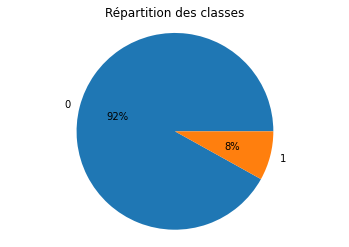

In [33]:
df_train['TARGET'].value_counts(normalize = True).plot(kind = 'pie', autopct = '%1.f%%', label = '')
plt.axis('equal') # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.title('Répartition des classes')
plt.show();

Les classes sont déséquilibrées. Je vais le prendre en compte et le gérer dans la partie modélisation.

# Analyse
## Univariée

In [34]:
df_train.drop(columns = ['SK_ID_CURR']).describe()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_CASH LOANS,NAME_CONTRACT_TYPE_REVOLVING LOANS,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP OF PEOPLE,NAME_TYPE_SUITE_INCONNU,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,"NAME_TYPE_SUITE_SPOUSE, PARTNER",NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL ASSOCIATE,NAME_INCOME_TYPE_MATERNITY LEAVE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_ACADEMIC DEGREE,NAME_EDUCATION_TYPE_HIGHER EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE HIGHER,NAME_EDUCATION_TYPE_LOWER SECONDARY,NAME_EDUCATION_TYPE_SECONDARY / SECONDARY SPECIAL,NAME_FAMILY_STATUS_CIVIL MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE / NOT MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO-OP APARTMENT,NAME_HOUSING_TYPE_HOUSE / APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL APARTMENT,NAME_HOUSING_TYPE_OFFICE APARTMENT,NAME_HOUSING_TYPE_RENTED APARTMENT,NAME_HOUSING_TYPE_WITH PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING STAFF,OCCUPATION_TYPE_COOKING STAFF,OCCUPATION_TYPE_CORE STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HIGH SKILL TECH STAFF,OCCUPATION_TYPE_HR STAFF,OCCUPATION_TYPE_INCONNU,OCCUPATION_TYPE_IT STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW-SKILL LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE STAFF,OCCUPATION_TYPE_PRIVATE SERVICE STAFF,OCCUPATION_TYPE_REALTY AGENTS,OCCUPATION_TYPE_SALES STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY STAFF,OCCUPATION_TYPE_WAITERS/BARMEN STAFF,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS ENTITY TYPE 1,ORGANIZA

## Bivariée
### Variables numériques

In [35]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [36]:
def corr_quali_quanti(df, listVarNum, listVarCat):
    df_corr = pd.DataFrame(columns = ['var'] + listVarCat)

    for x in listVarNum:
        for y in listVarCat:
            if df.shape[0] <= 5000:
                w, pvalueNorm = shapiro(df[x])
            else:
                w, pvalueNorm = normaltest(df[x]) # test K-carré de D'Agostino
            if pvalueNorm > 0.05: # distribution normale
                del w, pvalueNorm
                stat, p = levene(*[group[x].values for name, group in iris.groupby(y)])
                if p > 0.05: # variance égale
                    test = 'ANOVA' # ANOVA
                else: # pas de variance égale
                    test = 'NON' # test non-paramétrique
                del stat, p
            else: # pas distribution normale
                test = 'NON' # test non-paramétrique
            if test == 'ANOVA': # test ANOVA
                strMod = x + ' ~ C(' + y + ')'
                model = ols(strMod, data=df).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                if anova_table[0,-1] < 0.05: # possible corrélation
                    valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                    if len(df_corr[df_corr['var'] == x]) == 0:
                        dictRow = {'var' : x , y : valEtaSq}
                        for col in df_corr.columns:
                            if col not in ['var', y]:
                                dictRow[col] = np.nan
                        #df_corr = df_corr.append(dictRow, ignore_index=True)
                        df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                    else:
                        df_corr.iloc[df_corr['var'] == x, y] = valEtaSq
                del strMod, model, anova_table
            else: # test non paramétrique
                if df[y].nunique() > 2: # test de Kruskal-Wallis
                    # Faire le test
                    kstat, pval = kruskal(df[x], df[y].astype("category").cat.codes)
                    n = df[y].shape[0]
                    # Récupérer la p-value
                    if pval < 0.05: # possible corrélation
                        valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                        if len(df_corr[df_corr['var'] == x]) == 0:
                            dictRow = {'var' : x , y : valEtaSq}
                            for col in df_corr.columns:
                                if col not in ['var', y]:
                                    dictRow[col] = np.nan
                            #df_corr = df_corr.append(dictRow, ignore_index=True)
                            df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                        else:
                            df_corr.loc[df_corr['var'] == x, y] = valEtaSq
                    del kstat
                else: # test U de Mann-Whitney
                    a = df[y].unique()[0]
                    b = df[y].unique()[1]
                    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
                    mstat, pval = mannwhitneyu(x = df[df[y] == a][x], y = df[df[y] == b][x], alternative = 'two-sided')
                    # Récupérer la p-value
                    if pval < 0.05: # possible corrélation
                        valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                        if len(df_corr[df_corr['var'] == x]) == 0:
                            dictRow = {'var' : x , y : valEtaSq}
                            for col in df_corr.columns:
                                if col not in ['var', y]:
                                    dictRow[col] = np.nan
                            #df_corr = df_corr.append(dictRow, ignore_index=True)
                            df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                        else:
                            df_corr.iloc[df_corr['var'] == x, y] = valEtaSq
                    del a,b, mstat
                del test, pval

    return df_corr

In [37]:
# corrélation de la variable TARGET avec les variables numériques
df_corr = corr_quali_quanti(df_train[numCol+['TARGET']], numCol, ['TARGET'])
df_corr.sort_values(by = 'TARGET', ascending = False)

,var,TARGET
4,DAYS_BIRTH,0.0061
8,REGION_RATING_CLIENT_W_CITY,0.0037
7,REGION_RATING_CLIENT,0.0035
6,DAYS_ID_PUBLISH,0.0026
5,DAYS_REGISTRATION,0.0018
3,REGION_POPULATION_RELATIVE,0.0014
2,AMT_CREDIT,0.0009
9,HOUR_APPR_PROCESS_START,0.0006
0,CNT_CHILDREN,0.0004
1,AMT_INCOME_TOTAL,0.0000


### Variables catégorielles

In [38]:
def corr_quali_quali(df, listvarCat, varPred, df_res):
    for var in listvarCat:
        table = pd.crosstab(df[var],df[varPred], rownames = [var], colnames = [varPred])
        resultatTest = chi2_contingency(table)
        chi2 = resultatTest[0] # Statistique de test
        pvalue = resultatTest[1] # P-valeur
        libertyDegree = resultatTest[2] # Degré de liberté
        if pvalue < 0.05: # rejet de l’hypothèse selon laquelle les deux variables testées sont indépendantes
            n = sum(table.sum())
            result = round(np.sqrt(chi2 / (n * (min(table.shape) - 1)) ),4)
            dictRow = {'var':var, varPred:result}
            df_res = pd.concat([df_res,pd.DataFrame([dictRow])], ignore_index = False).reset_index(drop = True)
    
    return df_res

In [39]:
df_corr = corr_quali_quali(df_train, catCol, 'TARGET', df_corr)

In [40]:
df_corr.sort_values(by = 'TARGET', ascending = False)

,var,TARGET
43,NAME_INCOME_TYPE_WORKING,0.0575
45,NAME_EDUCATION_TYPE_HIGHER EDUCATION,0.0566
33,CODE_GENDER_F,0.0547
34,CODE_GENDER_M,0.0547
18,REG_CITY_NOT_WORK_CITY,0.0510
47,NAME_EDUCATION_TYPE_SECONDARY / SECONDARY SPECIAL,0.0498
40,NAME_INCOME_TYPE_PENSIONER,0.0462
101,ORGANIZATION_TYPE_XNA,0.0460
12,FLAG_EMP_PHONE,0.0460
17,REG_CITY_NOT_LIVE_CITY,0.0444


In [41]:
print("Il y a {} variables corrélées avec la variable à prédire.".format(df_corr.shape[0]))

Il y a 118 variables corrélées avec la variable à prédire.


# Exportation des données
## Données d'entrainement

In [42]:
print("Chargement du fichier d'entrainement...")
df_train.to_csv('data_train.csv', index = False)
print("Fichier de {:,} lignes et {} colonnes.".format(df_train.shape[0], df_train.shape[1]).replace(',',''))

Chargement du fichier d'entrainement...
Fichier de 307507 lignes et 760 colonnes.


## Données d'examination

In [43]:
print("Chargement du fichier d'examination...")
df_test.to_csv('API/dataviz/data_test.csv', index = False, compression = 'bz2')
df_test.to_csv('dashboard/data/data_test.csv', index = False, compression = 'bz2')
print("Fichier de {:,} lignes et {} colonnes.".format(df_test.shape[0], df_test.shape[1]).replace(',',''))

Chargement du fichier d'examination...
Fichier de 48744 lignes et 759 colonnes.
